**Name:** Yidu Wu

**EID:** yiduwu2

# CS5489 - Tutorial 4
## Face Detection in Images

In this tutorial you will train a classifier to detect whether there is a face in a small image patch.  This type of face detector is used in your phone and camera whenever you take a picture!

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
from scipy import stats
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import xgboost as xgb

## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [2]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 4  
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

1745
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


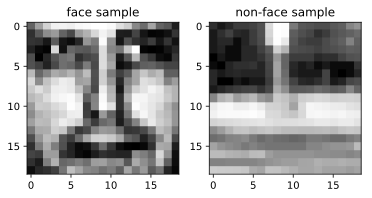

In [3]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

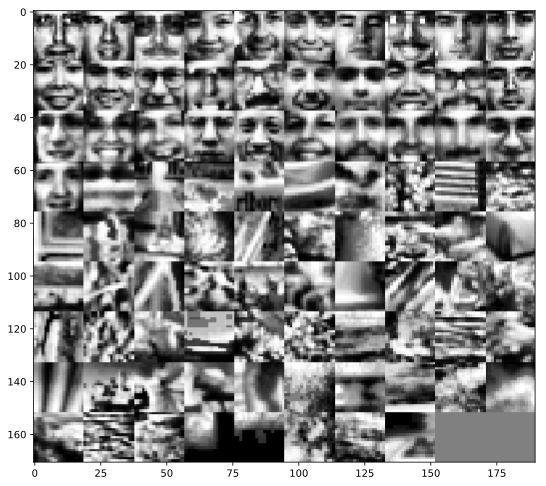

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(1745, 361)
(1745,)
(944, 361)
(944,)


## 2. Detection using  pixel values

Train an AdaBoost and GradientBoosting classifiers to classify an image patch as face or non-face.  Also train a kernel SVM classifier using either RBF or polynomial kernel, and a Random Forest Classifier.  Evaluate all your classifiers on the test set.

First we will normalize the features.

In [6]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

In [49]:
# AdaBoost
paramgrid = {'learning_rate': logspace(-6,0,20), 
             'n_estimators': array([10])
            }
print(paramgrid)
adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=5),paramgrid, cv=5, n_jobs=-1)
adacv.fit(trainXn, trainY);
print("best params:", adacv.best_params_)
predYAda = adacv.predict(testXn)
acc      = metrics.accuracy_score(testY, predYAda)
print("test accuracy =", acc)

{'learning_rate': array([1.00000000e-06, 2.06913808e-06, 4.28133240e-06, 8.85866790e-06,
       1.83298071e-05, 3.79269019e-05, 7.84759970e-05, 1.62377674e-04,
       3.35981829e-04, 6.95192796e-04, 1.43844989e-03, 2.97635144e-03,
       6.15848211e-03, 1.27427499e-02, 2.63665090e-02, 5.45559478e-02,
       1.12883789e-01, 2.33572147e-01, 4.83293024e-01, 1.00000000e+00]), 'n_estimators': array([10])}
best params: {'learning_rate': 0.4832930238571752, 'n_estimators': 10}
test accuracy = 0.6472457627118644


In [9]:
# GradientBoosting
import xgboost as xgb
xclf = xgb.XGBClassifier(objective="binary:logistic", random_state=4487)
paramgrid = {'learning_rate': logspace(-2,0,10), 
             'n_estimators': array([1])
            }
print(paramgrid)
xgbcv = model_selection.GridSearchCV(xclf, paramgrid, cv=5, n_jobs=-1)
xgbcv.fit(trainXn, trainY);
print("best params:", xgbcv.best_params_)
predYXgb = xgbcv.predict(testXn)
acc = metrics.accuracy_score(testY, predYXgb)
print("test accuracy =", acc)

{'learning_rate': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]), 'n_estimators': array([1])}


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best params: {'learning_rate': 0.01, 'n_estimators': 1}
test accuracy = 0.6324152542372882


In [12]:
# kernel SVM classifier using RBF
paramgrid = {'C': logspace(-2,2,10), 'gamma': logspace(-2,2,10) }
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid, cv=5,n_jobs=-1, verbose=True)
svmcv.fit(trainXn, trainY);
predYSvm = svmcv.predict(testXn)
acc  = metrics.accuracy_score(testY, predYSvm)
print("test accuracy =", acc)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished


test accuracy = 0.663135593220339


In [29]:
# Random Forest
paramsampler = {#'max_features': stats.uniform(0,1.0),
                 'max_depth':         stats.randint(1,5),
                 'min_samples_split': stats.uniform(0,0.5), 
                 'min_samples_leaf':  stats.uniform(0,0.5),
               }
clf = model_selection.RandomizedSearchCV(
                            ensemble.RandomForestClassifier(n_estimators=100, random_state=4487, n_jobs=-1),
                            param_distributions=paramsampler, 
                            random_state=4487, n_iter=1000, cv=5, 
                            verbose=1, n_jobs=-1)

#clf = ensemble.RandomForestClassifier(n_estimators=4, random_state=4487, n_jobs=-1)
clf.fit(trainXn, trainY)
predYRanF = clf.predict(testXn)
acc  = metrics.accuracy_score(testY, predYRanF)
print("test accuracy =", acc)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 10.0min finished


test accuracy = 0.652542372881356


_Which classifier was best?_
- **INSERT YOUR ANSWER HERE**
kernel SVM classifier using RBF performs better

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [13]:
# predY is the prediction from the classifier

Pind = where(predYSvm==1) # indicies for face predictions
Nind = where(predYSvm==0) # indicies for non-face predictions
TP = count_nonzero(testY[Pind] == predYSvm[Pind])
FP = count_nonzero(testY[Pind] != predYSvm[Pind])
TN = count_nonzero(testY[Nind] == predYSvm[Nind])
FN = count_nonzero(testY[Nind] != predYSvm[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 155
FP= 1
TN= 471
FN= 317
TPR= 0.3283898305084746
FPR= 0.00211864406779661


_How does the classifier make errors?_
- **INSERT YOUR ANSWER HERE**
The precision is high but the recall is very low, it means the model can distinguish faces with prominent features, but does not do well in face classification.

### Classifier analysis

For the AdaBoost classifier, we can interpret what it is doing by looking at which features it uses most in the weak learners.  Use the below code to visualize the pixel features used.

Note: if you used GridSearchCV to train the classifier, then you need to use the `best_estimator_` field to access the classifier.

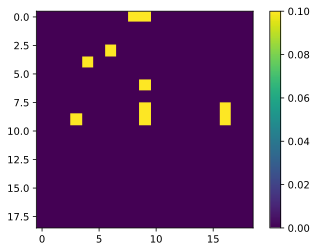

In [50]:
# adaclf is the trained adaboost classifier
fi = adacv.best_estimator_.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly, we can also look at the important features for xgboost.

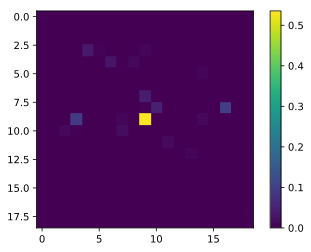

In [47]:
# xgbclf is the trained xgboost classifier
fi = xgbcv.best_estimator_.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly for Random Forests, we can look at the important features.

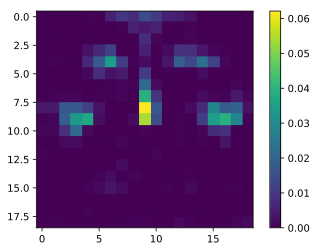

In [48]:
# rfclf is the trained random forest classifier
fi = clf.best_estimator_.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Comment on which features (pixels) that AdaBoost and Random Forests are using
- **INSERT YOUR ANSWER HERE** nose, eyes,cheek and so on

For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 376


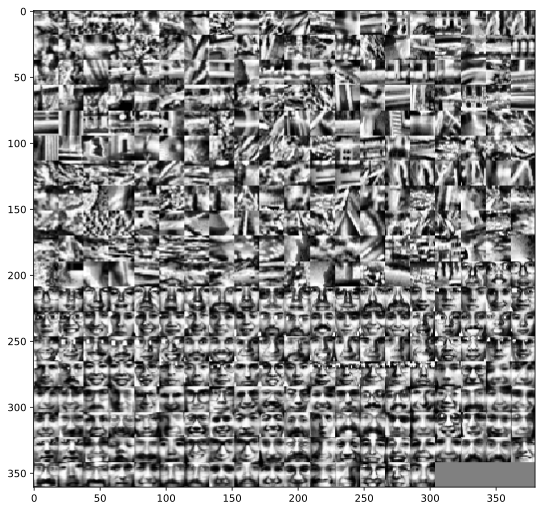

In [55]:
# svmclf is the trained SVM classifier

print("num support vectors:", len(svmcv.best_estimator_.support_vectors_))
si  = svmcv.best_estimator_.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
- **INSERT YOUR ANSWER HERE** on the decision boundary it's not liner, it can sovle some nolinear cases.

### Custom kernel SVM

Now we will try to use a custom kernel with the SVM.  We will consider the following RBF-like kernel based on L1 distance (i.e., cityblock or Manhattan distance),

$$ k(\mathbf{x},\mathbf{y}) = \exp \left(-\alpha \sum_{i=1}^d |x_i-y_i|\right)$$

where $x_i,y_i$ are the elements of the vectors $\mathbf{x},\mathbf{y}$, and $\alpha$ is the hyperparameter.  The difference with the RBF kernel is that the new kernel uses the absolute difference rather than the squared difference. Thus, the new kernel does not "drop off" as fast as the RBF kernel using squared distance.

- Implement the new kernel as a custom kernel function. The `scipy.spatial.distance.cdist` function will be helpful.
- Train the SVM with the new kernel.  To select the hyperparameter $\alpha$, you need to run cross-validation "manually" by: 1) trying different values of $\alpha$, and running cross-validation to select $C$; 2) selecting the  $\alpha$ with the highest cross-validation score `best_score_` in `GridSearchCV`.


In [56]:
from scipy import spatial

# create a custom kernel function
# Laplacian kernel: exp( -alpha*||x1-x2|| )
def mykernel(X1, X2, alpha=1.0):
    # X1,X2 are (N1 x d) and (N2 x d) matrices of N1 and N2 d-dim vectors
    # alpha is the hyperparameter
    
    # compute pairwise euclidean distance
    D = spatial.distance.cdist(X1, X2, metric='euclidean')
    
    # return the kernel matrix
    return exp(-alpha*D)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:   11.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    3.8s remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    5.8s remaining:   42.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    5.8s remaining:   42.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    3.9s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    5.6s remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    5.6s remaining:   41.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    5.8s remaining:   42.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    4.3s remaining:   31.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed:    5.2s remaining:   38.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.7s finished


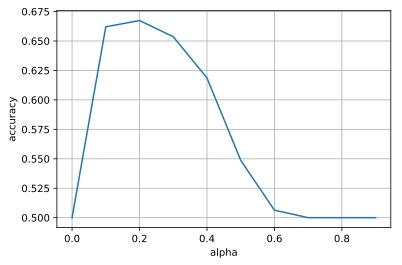

In [76]:
alphas = arange(0,1,0.1)
#clf = {}
Acc = []
paramgrid = {'C': logspace(-2,2,10)}
for i in alphas:
    # make a temporary kernel function with the selected alpha value
    tmpkern = lambda X1,X2,alpha=i: mykernel(X1,X2,alpha=alpha)
    # create the SVM with custom kernel function
    clf = model_selection.GridSearchCV(svm.SVC(kernel=tmpkern), paramgrid, cv=5,n_jobs=-1, verbose=True)
    #clf = svm.SVC(kernel=tmpkern,C=100)
    clf.fit(trainXn, trainY)
    predY = clf.predict(testXn)
    acc = metrics.accuracy_score(testY, predY)
    Acc.append(acc)

x = alphas
plt.plot(x,Acc)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.show()

Does using the new kernel improve the results?
- **INSERT YOUR ANSWER HERE** It seems not

## 3. Image Feature Extraction
The detection performance is not that good. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [77]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


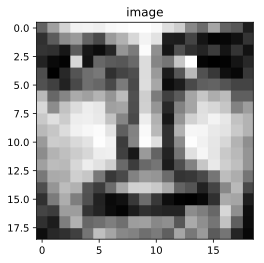

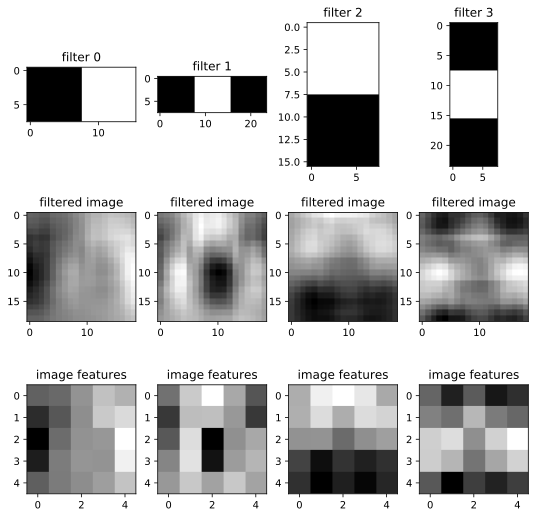

In [78]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [79]:
trainXf = extract_features(imgdata['train'])
print(trainXf.shape)
testXf = extract_features(imgdata['test'])
print(testXf.shape)

(1745, 100)
(944, 100)


### Detection using Image Features
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [80]:
# first scale the features
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn  = scalerf.transform(testXf)        # apply scaling to test data

In [81]:
# AdaBoost
paramgrid = {'learning_rate': logspace(-4,0,10), 
             'n_estimators': array([10])
            }
print(paramgrid)
adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=5),paramgrid, cv=5, n_jobs=-1)
adacv.fit(trainXfn, trainY);
print("best params:", adacv.best_params_)
predYAda = adacv.predict(testXfn)
acc      = metrics.accuracy_score(testY, predYAda)
print("test accuracy =", acc)

{'learning_rate': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00]), 'n_estimators': array([10])}
best params: {'learning_rate': 1.0, 'n_estimators': 10}
test accuracy = 0.7722457627118644


In [82]:
# kernel SVM classifier using RBF
paramgrid = {'C': logspace(-2,2,10), 'gamma': logspace(-2,2,10) }
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid, cv=5,n_jobs=-1, verbose=True)
svmcv.fit(trainXfn, trainY);
predYSvm = svmcv.predict(testXfn)
acc  = metrics.accuracy_score(testY, predYSvm)
print("test accuracy =", acc)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   48.5s finished


test accuracy = 0.7542372881355932


### Error Analysis
Repeat the error analysis for the new classifiers.

In [83]:
### AdaBoost
Pind = where(predYAda==1) # indicies for face predictions
Nind = where(predYAda==0) # indicies for non-face predictions
TP = count_nonzero(testY[Pind] == predYAda[Pind])
FP = count_nonzero(testY[Pind] != predYAda[Pind])
TN = count_nonzero(testY[Nind] == predYAda[Nind])
FN = count_nonzero(testY[Nind] != predYAda[Nind])
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 303
FP= 46
TN= 426
FN= 169
TPR= 0.6419491525423728
FPR= 0.09745762711864407


In [84]:
### kernel SVM classifier using RBF
Pind = where(predYSvm==1) # indicies for face predictions
Nind = where(predYSvm==0) # indicies for non-face predictions
TP = count_nonzero(testY[Pind] == predYSvm[Pind])
FP = count_nonzero(testY[Pind] != predYSvm[Pind])
TN = count_nonzero(testY[Nind] == predYSvm[Nind])
FN = count_nonzero(testY[Nind] != predYSvm[Nind])
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 249
FP= 9
TN= 463
FN= 223
TPR= 0.527542372881356
FPR= 0.019067796610169493


How has the classifier using image features improved?
- **INSERT YOUR ANSWER HERE** As we can see that the value of TPR is higher, it means that the model performs better in face classification.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [85]:
fname = "nasa-small.png"

(210, 480)


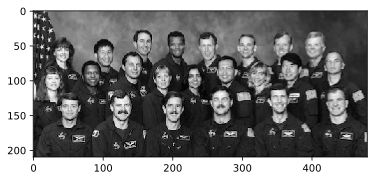

In [86]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [87]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print(patches2.shape )

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568, 19, 19)


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Now predict using your classifier.  The extracted features are in `newXf`, and scaled features are `newXfn`.

In [89]:
newXfn  = scalerf.transform(newXf)        # apply scaling to test data

In [91]:
# AdaBoost
prednewY = adacv.predict(newXfn)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

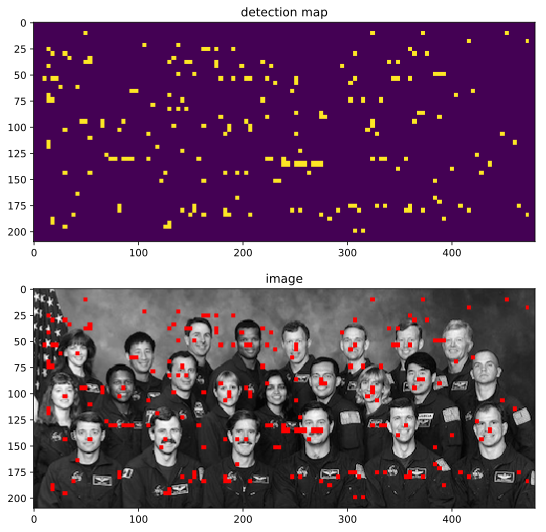

In [92]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_
- **INSERT YOUR ANSWER HERE** Maybe 60 percent of the accuracy.Actually I think it does a pretty good job of recognizing nose features

You can try it on your own images.  The faces should all be around 19x19 pixels though.
We only used 1/4 of the training data. Try using more data to train it!